## Pre-reading

Before reading these notes, I recommend looking at the following 2 points in the tutorial on random simulation:
- Event occuring with probability $p$
- Choosing a random element from a list with equal probability

Initially just skim over them so you have an idea of what is going on.  When you get to exercises trying to implement a stochastic simulation, look at those parts in more detail.

# PageRank

Google has made a lot of people very rich by providing a widely-used search engine. We are going to learn about the PageRank algorithm which was the basis of the original ranking algorithm they used for ranking websites (historical note: I've been told it was named after Larry Page, rather than as an algorithm for ranking pages).

## Motivation

We're going to build up a PageRank algorithm.  To help motivate it, consider the following:

Before the days of Google, someone who wanted to do a web search would type a term into a search engine.  The pages would be ranked roughly by the frequency of the search term.  Then the searcher would choose one of the pages that showed up highly ranked.  Possibly the searcher would then start following links for a while.  Eventually the searcher would either find the page of interest or go back to the search engine and choose another page.

Here is a rough model of that process:

- A surfer starts at a random page.   
- Then the surfer follows the following two steps 
  - with some probability $\alpha$, the surfer chooses a random page, sometimes this is called **'teleporting'**.  
  - otherwise (with probability $1-\alpha$) the surfer chooses a random link to follow from the current page.  (if the current page has no out-links, the surfer chooses a random page).
  
The idea is that the pages that are most frequently visited by this process are likely to be the best pages.  In other words, by studying random surfers on a network, we will learn some property of the network.  We're going to build a stochastic simulation of this process, and then develop a method to predict the probability of being at a given page at a given time.  Eventually we'll use Linear Algebra to analyze this process.

## Analyzing the PageRank process.

Our first step in understanding PageRank is going to be building a stochastic simulation which produces a random walk through the webpages according to the rules for the surfer above.  This stochastic simulation is **not** the PageRank Algorithm.  The **PageRank vector** is a vector which represents how often random surfers would visit each page after many steps.

PageRank ranks pages based on their probabilities in the PageRank vector.  The simulation above is instructive, but it is not the best algorithm to calculate the PageRank vector.  Instead for the **PageRank Algorithm** we will come up with a direct calculation of the probabilities at each step.

Finally we will build a linear algebra interpretation of PageRank.  This could lead to a faster calculation of the PageRank vector (though we won't attempt it) using numpy.  The reason numpy would be faster is that the underlying calculations are actually performed using a compiled language (I believe Fortran).  The main value for us of the linear algebra interpretation is that it lets us determine whether or not we can guarantee that the PageRank Algorithm will give meaningful results (especially, will it converge, and will it converge to the same thing even if we provide it a different initial guess).

For a first pass, let's **assume that all nodes have positive out-degree**.

### Building the stochastic simulation process underlying the PageRank algorithm

We start by simulating a random surfer moving through the network, with a probability $\alpha$ at any step of jumping/teleporting to a random page.  The tutorial on stochastic simulation may be useful if some of the steps we do seem unclear.

In this introduction, I'll provide some of the steps and guide the implementation of other steps through exercises.

We are going to use tools from both networkx and random. So we need to import both of them


In [1]:
import networkx as nx
import random

Now we'll define a very simple DiGraph (directed graph) satisfying our assumption that all nodes have positive out-degree.

In [2]:
G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (1,3), (2,4), (3,4), (4,1)])

For reference, this is what the graph looks like:

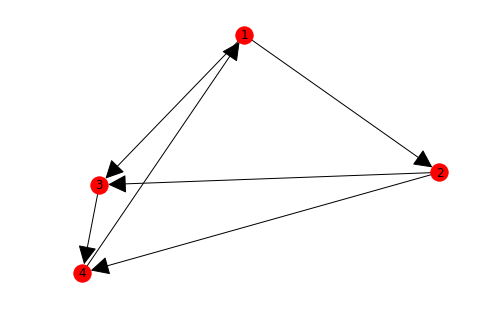

In [3]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True, arrowsize = 40) #the 'with_labels' and 'arrowsize' arguments are 
                                             #examples of optional arguments.  I could leave
                                             #them out and the command would still draw a
                                             #graph, but the nodes wouldn't be labelled and
                                             #the arrows would be smaller.
plt.show()

We'll create a dict to track the frequency with which the surfer will visit each node.

**self-test** why am I using a dict rather than a list?  And how would the syntax I use below be different if I were creating a list?

In [4]:
visit_count = {}           #create the dict which will count how often 
                           #each node has been visited.
    
for node in G.nodes():     #we'll initialize the values.
    visit_count[node] = 0  #for more advanced users of python, we could avoid the 
                           #initialization
                           #by using something called a `defaultdict` from `collections`.

A brief aside:
- If you've worked through the entire python tutorial I've provided including the **dict comprehensions**, see if you can replace the code above with a single line.
- If you're a fairly experience python programmer, you may be interested in knowing there is an alternate way to define `visit_count` as a `defaultdict` which would avoid the need to initialize it.

We'll take $\alpha=0.1$, so our next line is

In [5]:
alpha = 0.1

We've got things ready to start the simulation, now we need to place our random surfer at an initial node, and then write down a loop for the steps.

To choose our random surfer's initial location, we need to choose a random node from the available nodes.  Based on the description in the stochastic simulation code, you might expect that `random.choice(G.nodes())` would work because `G.nodes()` gives us the nodes of `G`.  Recall that `random.choice(L)` will choose an element from a **list** `L` uniformly at random.

In early versions of networkx, this would work because `G.nodes()` would be a **list** of all the nodes of `G`.  In more recent versions this is no longer the case.  This is because if we want to do something with the nodes or the edges of a very large network, it may be inefficient either in memory or time to create a list of all of them.  Instead Python provides a range of tools to let us look at one thing at a time from a sequence and only calculate the next thing when we're ready to look at it.  There is a simple workaround which is to use `list(G.nodes())` which converts `G.nodes()` into a list (forcing it to immediately do the calculations it's trying to postpone).  We'll do this command many times so, let's save the list of nodes for future reference

In [6]:
NodeList = list(G.nodes())
print(NodeList)

[1, 2, 3, 4]


**Exercise**  
Please provide the code to choose a random node from `G`, using the `NodeList` defined above and update `visit_count` for the initial node.

In [12]:
initial_node = random.choice(NodeList)

visit_count[initial_node] += 1

Define a variable `iterations = 10000` and create a loop that will go through iterations steps (don't forget the indentation needed in a loop).  In each pass through the loop, the surfer either goes to a random node (with probability $\alpha$) or otherwise it follows a random link from the current node.  

When following a random link, the same `list` trick is needed again to choose a random destination.  In a directed network, you can access the nodes reached by following edges **from** `u` through `G.successors(u)`.  You can convert this to a list through `list(G.successors(u))`.

Each time update `visit_count` for the resulting node.

In [13]:
iterations = 10000

current_node = initial_node
for counter in range(iterations):
    if random.random() < alpha:
        next_node = random.choice(NodeList)
    else:
        next_node = random.choice(list(G.successors(current_node)))
    visit_count[next_node] += 1
    current_node= next_node  #note since we never used current_node between 
                             #finding next_node and this step, we didn't neeed to
                             #maintain separate names for them.

Calculate the proportion of time at each node (this will involve dividing by `iterations+1`, rather than by `10001` because you want the code to still work if later you decide to change the number of iterations).

In [15]:
for node in G.nodes():
    print(node, visit_count[node]/(iterations+1))

1 0.3000699930006999
2 0.1635836416358364
3 0.23167683231676833
4 0.3046695330466953


Now we reset the memory so that our code below is self-contained and definitely doesn't depend on anything we've defined above.

In [16]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Put all of the code into a single block.  Rerun it with 100000 steps, finding the proportion of time at each node.

In [18]:
import networkx as nx
import random

G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (1,3), (2,4), (3,4), (4,1)])


alpha = 0.1
NodeList = list(G.nodes())

visit_count = {}           #create the dict which will count how often 
                           #each node has been visited.
    
for node in G.nodes():     #we'll initialize the values.
    visit_count[node] = 0  #for more advanced users of python, we could avoid the 
                           #initialization
                           #by using something called a `defaultdict` from `collections`.

initial_node = random.choice(NodeList)
visit_count[initial_node] += 1

iterations = 100000

current_node = initial_node
for counter in range(iterations):
    if random.random() < alpha:
        next_node = random.choice(NodeList)
    else:
        next_node = random.choice(list(G.successors(current_node)))
    visit_count[next_node] += 1
    current_node= next_node  #note since we never used current_node between 
                             #finding next_node and this step, we didn't neeed to
                             #maintain separate names for them.
            
for node in G.nodes():
    print(node, visit_count[node]/(iterations+1))

1 0.3007569924300757
2 0.15981840181598184
3 0.23362766372336277
4 0.3057969420305797


### Relation to ergodicity

I make the claim that this system is "ergodic".  That is, the proportion of time the surfer spends at a given node in the first $T$ steps (for large enough $T$) is equal to the probability of being at that node at step $T$ (again for large enough $T$).  Rigorously, "large enough $T$" should be replaced by "$T \to \infty$".

To show this, please run your simulation for 100000 time steps, and have it print out the final node.  Then go to this [google drive page](https://docs.google.com/spreadsheets/d/1IbNMSRPRJQlCiSmlpergtCWgEZ4-LpVXjDAxgPZ43tQ/edit?usp=sharing) and report the final node.  Repeat this process 10 times.

We'll check that the frequencies we find from everyone's 100000'th time step matches what you've found for the first 100000 time steps.


##### What could something non-ergodic look like?
note here is an example where there is a limit to what happens in the first $T$ steps, but $\vec{x}(t)$ doesn't converge:
\begin{align*}
\vec{x}(1) &= \begin{pmatrix} 0.5, 0.25, 0.25 \end{pmatrix}^T\\
\vec{x}(2) &= \begin{pmatrix} 0.25, 0.5, 0.25 \end{pmatrix}^T\\
\vec{x}(3) &= \begin{pmatrix} 0.25, 0.25, 0.5 \end{pmatrix}^T\\
\vec{x}(4) &= \begin{pmatrix} 0.5, 0.25, 0.25 \end{pmatrix}^T\\
& \vdots
\end{align*}
After many steps, the proportion of time at each node would approach $1/3$, but $\vec{x}$ does not approach $\begin{pmatrix} 1/3, 1/3, 1/3 \end{pmatrix}^T$.


### Implementing the PageRank algorithm

Based on the **thus far unproven claim** of ergodicity, we anticipate that if we calculate the vector $\vec{x}(t)$ giving the probability of being at each page on step $t$, then as $t \to \infty$ we expect $\vec{x}(t)$ to approach a limit.  Indeed, it turns out that approaching a limit is equivalent to being ergodic.  So let's try to calculate $\vec{x}(t)$ and see if it approaches a limit (later we'll discuss the conditions under which we can prove it approaches a limit).

Let $\vec{x}(t)$ be the vector showing the probabilities at the $t$-th step.  Let's try to work out the probability $x_i(t)$ of being at page $i$ on the $t$-th step of the surfer.  

In practice it is simple to do the calculation by taking
\begin{equation*}
x_j(t) = \frac{\alpha}{N} + (1-\alpha)\sum_{i\to j} \frac{x_i(t-1)}{d_i}
\end{equation*}
where the sum is taken over all $i$ with edges to $j$ and $N$ is the number of nodes of the network.


**Exercise**  
Derive this equation for $x_j(t)$.

**start derivation**

The probability of $x_j(t)$ given $\vec{x}(t-1)$ is calculated by figuring out the probability of arriving at $j$ from a teleport step plus the probability of arriving from a non-teleport step.

The probability of arriving from a teleport step is $\alpha/N$.  

The probability of arriving from a non-teleport step is $(1-\alpha)$ times the probability of arriving given that it is non-teleport.

We'll divide those non-teleport steps into what happens for each separate node the surfer could be at in the previous step.  If the walker is at a node $i$ with no edge to $j$ then it cannot arrive at $j$ by a non-teleport step.  If the walker is at node $i$ which has an edge to $j$ at $t-1$ and the teleport is not happening , then it arrives at node $j$ with probability $1/d_i$ (i.e., it selects an edge to $j$ with probability 1/d_i$).  So the non-teleport probability from $i$ if the edge exists is $x_i(t-1) (1-\alpha) /d_i$.

Thus we get $\frac{\alpha}{N} + (1-\alpha)\sum_{i \to j} x_i(t-1)/d_i$

**end derivation**

We are now going to define a function `PageRank(G, alpha, iterations)`  (the python tutorial has a discussion of how to define functions.

This function will take in a graph, a value of $\alpha$ and a number of iterations to run.  It will initialize a dict which contains the initial uniform probabilities corresponding to $\vec{x}(0)$.  In each iteration it will take the probabilities of the previous iteration and create a new dict into which it will store the probabilities for the next step.  This will be fed into the next iteration.

In the code below, please fill in details where the `pass` commands are used.


In [21]:
def PageRank(G, alpha, iterations):
    N = G.order() #count the number of nodes in G which we'll need
    
    probabilities = {node: 1./N for node in G.nodes()}  #the initial values
    
    for counter in range(iterations):
        new_probabilities = {node:0 for node in G.nodes()}  #initialize for all nodes.
        for node in G:
            new_probabilities[node] = alpha/N
            for predecessor in G.predecessors(node): #the nodes with edges to `node`.
                new_probabilities[node] += (1-alpha)*probabilities[predecessor]/G.out_degree[predecessor] 
        probabilities = new_probabilities  #can you tell why we need a separate 
                                           #probabilities and new_probabilities dict?
    return probabilities


In [22]:
def AlternatePageRank(G, alpha, iterations): #equivalent to above, but loops through differently
    N = G.order() #count the number of nodes in G which we'll need
    
    probabilities = {node: 1./N for node in G.nodes()}  #the initial values
    
    for counter in range(iterations):
        new_probabilities = {node:0 for node in G.nodes()}  #initialize for all nodes.
        for node in G:
            new_probabilities[node] = alpha/N
        for node in G:
            di = G.out_degree[node]
            for successor in G.successors(node): #the nodes with edges to `node`.
                new_probabilities[successor] += (1-alpha)*probabilities[node]/di
        probabilities = new_probabilities  #can you tell why we need a separate 
                                           #probabilities and new_probabilities dict?
    return probabilities
    

Note that this code is a little different from what I gave in an earlier version 
- Here we loop through the nodes and give each its appropriate weight from its "predecessors".
- The code I previously wrote loops through the nodes and gives its weight to the successors.
The code here has a danger of introducing a bug once we have nodes with no out-edges.  If they get nonzero weight, and we don't correctly adapt the code their weight will be lost (and probabilities won't sum to 1).  The other version would still have the same problem, but it's more obvious how to modify the code. 

I provide both versions in the "worked" version of this notebook.

You might want to check results using your PageRank function against [those of networkx](https://networkx.github.io/documentation/stable/reference/algorithms/link_analysis.html) (there are 3).

Let's just check that this seems to converge for our Graph by calculating the probability of being at a given point at two consecutive (large) steps.  **It would be pretty bad to rank nodes with an algorithm that doesn't converge, right?**

In [25]:
PageRank_values = PageRank(G, 0.1, 500)
print(PageRank_values, '\n')

PageRank_values = PageRank(G, 0.1, 501)
print(PageRank_values)

{1: 0.3007606534704816, 2: 0.1603422940617167, 3: 0.23249632638948925, 4: 0.30640072607831287} 

{1: 0.3007606534704816, 2: 0.1603422940617167, 3: 0.23249632638948925, 4: 0.30640072607831287}


For good measure, I'll show that the alternate version also works

In [26]:
PageRank_values = AlternatePageRank(G, 0.1, 500)
print(PageRank_values, '\n')

PageRank_values = AlternatePageRank(G, 0.1, 501)
print(PageRank_values)

{1: 0.3007606534704816, 2: 0.1603422940617167, 3: 0.23249632638948925, 4: 0.30640072607831287} 

{1: 0.3007606534704816, 2: 0.1603422940617167, 3: 0.23249632638948925, 4: 0.30640072607831287}


### Mathematical Framework

Before we get into the mathematical framework, let's see some hints that there's something to it.

#### Relation to eigenvectors

The adjacency matrix $A$ of the graph `G` has entry $1$ in the $i,j$ component if node $i$ has an edge to node $j$.  Otherwise the entry is $0$.

Let $d_i$ denote the number of out-edges of node $i$.  So $d_1 = 2$, $d_2 = 2$, $d_3=1$, and $d_4 = 1$.

Define the matrix $P$ so that its $i,j$ entry is $\frac{\alpha}{4} + (1-\alpha) A_{ij} / d_i$.  This entry gives the probability that a surfer who is at node $i$ ends up at node $j$ in the next time step. 

**Exercise**  
Convince yourself that this is the correct probability of going from $i$ to $j$ (including the possibility of a teleport step).

**Exercise**  
Just **before** the discussion of **ergodicity** above, you were asked to find the vector of proportions that each page is visited.  

Check by hand that $P^T$ (transpose of $P$) times the vector of proportions found above is approximately the same vector.

**Exercise before reading the discussion below**  
Look up the Perron Frobenius Theorem, and think about the relationship.  [the discussion below provides the answer]

**Exercise for before Wed's first lecture:**  
Read sections 1 and 2 of [The \$25,000,000,000 Eigenvector: The Linear Algebra behind Google](https://epubs.siam.org/doi/pdf/10.1137/050623280).  This is available on LMS as "google_eigenvector"

### Equivalence of PageRank Algorithm to a matrix multiplication

It helps to turn this into a matrix problem.
 
Let's use our existing graph and find $\vec{x}(t)$ in terms of  $\vec{x}(t-1)$ for $t>0$.  We will do this component by component.
 
To arrive at node $1$, the surfer must either arrive there by going to a random page (which occurs with probability $\alpha/4$), or it arrives there from page $4$, which occurs with probability $(1-\alpha) x_4(t-1)$.   
\begin{equation*}
 x_1(t) = \frac{\alpha}{4} + (1-\alpha) x_4(t-1)\\
\end{equation*}
For $x_2(t)$ we again have the $\alpha/4$ term, but because there are two places to jump from $x_1$ we also have $(1-\alpha) x_1(n-1)/2$.  So
\begin{equation*}
x_2(t) = \frac{\alpha}{4} + (1-\alpha) \frac{x_1(t-1)}{2}
\end{equation*}
For $x_3(t)$ and $x_4(n)$ we find
\begin{align*}
x_3(t) &= \frac{\alpha}{4} + (1-\alpha) \left( \frac{x_1(t-1)}{2} + \frac{x_2(t-1)}{2}\right)\\
x_4(t) &= \frac{\alpha}{4} + (1-\alpha) \left( \frac{x_2(t-1)}{2} + x_3(t-1)\right)
\end{align*}

We will convert this to a matrix equation looking like:
\begin{equation*}
\vec{x}(n) = P \vec{x}(n-1) 
\end{equation*}
We start with 
\begin{align*}
x_1(t) &= \frac{\alpha}{4} + (1-\alpha)\left[ x_4(t-1)\right]\\
x_2(t) &= \frac{\alpha}{4} + (1-\alpha)\left[\frac{x_1(t-1)}{2}\right]\\
x_3(t) &= \frac{\alpha}{4} + (1-\alpha)\left[\frac{x_1(t-1)}{2} + \frac{x_2(t-1)}{2}\right]\\
x_4(t) &= \frac{\alpha}{4} + (1-\alpha)\left[\frac{x_2(t-1)}{2} + x_3(t-1)\right]
\end{align*}
So
\begin{equation*}
\vec{x}(t) = \frac{\alpha}{4} \begin{pmatrix}1\\1\\1\\1\end{pmatrix} + (1-\alpha) \begin{pmatrix}
0 & 0 & 0 & 1\\
1/2 & 0 & 0 & 0\\
1/2 & 1/2 & 0 & 0\\
0 & 1/2 &  1 & 0
\end{pmatrix}
\vec{x}(t-1)
\end{equation*}
Notice that the entries of $\vec{x}(t-1)$ sum to $1$ since it is a vector of probabilities.
Thus we can write
\begin{equation*}
\begin{pmatrix}1\\1\\1\\1\end{pmatrix} = \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
\end{pmatrix}  \vec{x}(t-1)
\end{equation*}
This yields
\begin{equation*}
\vec{x}(t) = \frac{\alpha}{4} \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
\end{pmatrix}  \vec{x}(t-1)
\quad +\quad (1-\alpha) \begin{pmatrix}
0 & 0 & 0 & 1\\
1/2 & 0 & 0 & 0\\
1/2 & 1/2 & 0 & 0\\
0 & 1/2 &  1 & 0
\end{pmatrix}
\vec{x}(t-1)
\end{equation*}
Factoring out $\vec{x}(t-1)$ yields
\begin{equation*}
\vec{x}(t) = P\vec{x}(t-1)
\end{equation*}
where the matrix $P$ is
\begin{equation*}
P = \frac{\alpha}{4} \begin{pmatrix}
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
\end{pmatrix} 
+ (1-\alpha)
\begin{pmatrix}
0 & 0 & 0 & 1\\
1/2 & 0 & 0 & 0\\
1/2 & 1/2 & 0 & 0\\
0 & 1/2 &  1 & 0
\end{pmatrix}
\end{equation*}

The matrix $P$ has an important property.  If I multiply it into any vector $\vec{x}$ of probabilities (i.e., the entries in $\vec{x}$ are non-negative and sum to $1$), then the result is also a vector of probabilities.  We call such matrices **stochastic matrices**.  A matrix is a stochastic matrix if its entries are all non-negative and its columns each sum to $1$. 

#### Some properties of eigenvalues of stochastic matrices (not using the Perron-Frobenius Theorem)

We have a few important results about the eigenvalues of any stochastic matrix $P$

1. The eigenvalues of $P$ are the same as the eigenvalues of $P^T$.  [the proof of this is that the characteristic polynomials of $P$ and $P^T$ are the same].

2. If $\vec{v}_i$ is an eigenvector of $P$ with eigenvalue $r_i$ and $\vec{w}_j$ is an eigenvector of $P^T$ with eigenvalue $r_j$ with $r_i \neq r_j$, then $\vec{w}_j \cdot \vec{v}_i = 0$.  [the proof is by considering $\vec{w}_j^T P \vec{v}_i$.  If we group it like $\left(\vec{w}_j^T P\right) \vec{v}_i$ we use the fact that $\vec{w}_j^T P = (P^T \vec{w}_j)^T = (r_j \vec{w}_j)^T$ to get $r_j \vec{w}_j^T \vec{v}_i$.  Alternately we group it like $\vec{w}_j^T \left(P \vec{v}_i\right)$ we use the fact that $P \vec{v}_i = r_i \vec{v}_i$ to get $r_i \vec{w}_j^T \vec{v}_i$.  This leads to the conclusion that $r_j \vec{w}_j^T \vec{v}_i = r_i \vec{w}_j^T \vec{v}_i$.  Since $r_i \neq r_j$ we conclude $\vec{w}_j^T \vec{v}_i=[0]$.  So $\vec{w}_j \cdot \vec{v}_i = 0$.  

3. One eigenvalue of $P^T$ is $r=1$ and it has an eigenvector $\begin{pmatrix}1 \\ 1\\ \vdots \\ 1 \end{pmatrix}$.  [the proof of this is simply to multiply $P^T$ (whose rows will each sum to 1) by the vector and conclude that the outcome is $1$ times that vector].

4. Any eigenvector of $P$ with eigenvalues other than $r=1$ must sum to $0$.  [The proof of this is that the eigenvector must be orthogonal to the vector $\begin{pmatrix}1 \\ 1\\ \vdots \\ 1 \end{pmatrix}$ because of the last two results above].

5. The eigenvalues of $P$ are all within the unit circle (possibly with radius $1$).  [The proof of this uses Gershgorin's circle theorem which I proved in class - you can see the same proof [here](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem), which shows that any eigenvalue of $P^T$ lies within some disc in the complex plane whose center is at some diagonal entry $P_{ii}$ and whose radius is the sum of the absolute values of the off-diagonal entries of $P^T$ of the same row.  Since those entries are non-negative, and they sum to $1-P_{ii}$, which lies within the unit circle.]



So far our theorems tell us that our matrix $P$ has an eigenvalue $1$.  All other eigenvalues have modulus at most $1$ and the entries of their eigenvectors sum to zero.  It is possible that $1$ could be repeated.  For now, though, we know enough to look at power iteration. 

Ultimately we won't need these results because ultimately the Perron-Frobenius theorem which we give later (without proof) includes all of these results and more.

#### Power iteration (stochastic matrix case)

Given a general $N\times N$ stochastic matrix $\hat{P}$, assume that it has eigenvalues $r_1, r_2, \ldots, r_N$, ordered so that $r_1=1$, and $|r_1| \geq |r_2| \geq \cdots \geq |r_N|$.  It is possible that some of these $r_i$ are repeated in the list.  We have proven that $r_1=1$, but it is possible that $1$ is repeated and that there are other eigenvalues of magnitude $1$.  

We will assume for simplicity that all eigenvalues have a full eigenspace, so that $\hat{P} \vec{v}_i = r_i \vec{v}_i$ and for any repeated eigenvalue the corresponding $\vec{v}_i$ are linearly independent.

We take some initial vector of probabilities $\vec{x}(0)$.  Because all eigenvalues have a full eigenspace we can write
\begin{equation*}
\vec{x}(0) = \sum c_i \vec{v}_i 
\end{equation*}
Because $\vec{x}(0)$ is a vector of probabilities the sum of its entries is nonzero.  Since only eigenvectors of $1$ have nonzero sums, we can assume that $c_1 \neq 0$.

Then 
\begin{align*}
\hat{P}\vec{x}(0) &= \sum \hat{P} c_i \vec{v}_i\\
            &= \sum c_i r_i \vec{v}_i
\end{align*}
beause $r_i$ and $\vec{v}_i$ are an eigenvalue-eigenvector pair for $M$.  Indeed for repeated multiplication, we reach
\begin{equation*}
\hat{P}^t \vec{x}(0) = \sum c_i r_i^t \vec{v}_i
\end{equation*}
[notice the superscript $t$ is a power $t$].

Then as $t \to \infty$, if $|r_i|<1$  then $r_i^t \to 0$.  So eventually the only terms left in the sum are those whose eigenvalues have modulus $1$.


#### Power iteration for our specific matrix

Our matrix $P$ has all positive diagonal entries.  From this the Gershgorin circle theorem tells us a little more.  We know that each eigenvalue lies within some disc centered at a diagonal entry $P_{ii}$ with radius $1-P_{ii}$.  That disc only touches the unit circle at $1$.  So the only eigenvalue with modulus $1$ is $1$.  This doesn't prove that the eigenvalue $1$ is simple (not repeated).  We'll get to that later.

Because the only eigenvalue of modulus $1$ is $1$ (possibly repeated), we see that in the sum above $r_i^t$ becomes $1^t$ for those specific $i$ values.  Thus the result converges.  We aren't yet guaranted that the result is unique - a different initial probability vector might lead to a different outcome.

Note that the PageRank algorithm corresponds to power iteration.  So we are guaranteed a limit, even if so far we aren't guaranteed a unique limit.

#### The Perron-Frobeneous Theorem:

We'll now use a stronger theorem, the Perron-Frobenius Theorem.  It comes in several varieties, depending on whether the entries of the matrix are all positive (as in our case), or, if some are zero, exactly which are zero.



##### The Perron-Frobenius Theorem when $M$ has all positive entries

Given an $N\times N$ matrix $M$ with all positive entries,
- $M$ has a positive eigenvalue $r_1$ such that all other eigenvalues have smaller modulus.
- The eigenvalue $r_1$ is simple (not repeated).
- The eigenvector of $r_1$ can be chosen to have all positive entries.
- No other eigenvalue has an eigenvector with all positive entries.

The dominant eigenvalue $r_1$ is known as the Perron-Frobenius eigenvalue and its (positive) eigenvector is known as the Perron-Frobenius eigenvector.

For our matrix $P$, we know that $r_1=1$.  This theorem guarantees that **the PageRank algorithm converges to a unique limit.**



##### The Perron-Frobenius Theorem when the matrix has 0 entries.

Notice that if $\alpha = 0$, this theorem wouldn't apply.  Let's see what we can learn in that case.

First we'll define an irreducible matrix.  Given an $N \times N$ matrix $M$ with non-negative entries, create a directed graph $H$ with an edge from $i$ to $j$ if and only if $M_{ij}>0$.  **The matrix $M$ is called irreducible** if it is possible to get from any node in $H$ to any other node in $H$ by following edges (in the correct direction).

[note a directed graph $H$ for which we can get from any node to any other node is said to be "strongly connected"].

There are other equivalent ways to define irreducible, but given that we're interested in networks, this is the best version to use.

###### Perron-Frobenius for irreducible matrices:

Let $M$ be an irreducible matrix.  Then
- $M$ has a positive eigenvalue $r_1$ such that all other eigenvalues have modulus at most $r_1$.  
- The eigenvalue $r_1$ is simple (not repeated).
- Any other eigenvalue of modulus $r_1$ is of the form $r_i = r_1 \omega$ where $\omega^h=1$ for some power $h$.
- The eigenvector of $r_1$ can be chosen to have all positive entries.
- No other eigenvalue has an eigenvector with all positive entries.

The dominant eigenvalue $r_1$ is known as the Perron-Frobenius eigenvalue and its (positive) eigenvector is known as the Perron-Frobenius eigenvector.

For our matrix $P$, we know that $r_1=1$, so the other eigenvalues of modulus $1$ are roots of unity.

This theorem does not prove that PageRank converges when $\alpha = 0$.  However, we can use the fact the modulus $1$ eigenvalues are all roots of unity that the iteration converges to a periodic cycle.

###### Perron-Frobenius Theorem for  non-negative matrices.

If $M$ has only non-negative entries then we an generate the graph $H$ used in the definition of irreducibility.  We can apply the Perron-Frobenius theorem to each strongly-connected component separately.  

It turns out that in this case we reach the conclusion that in the PageRank algorithm each strongly connected component may have a periodic cycle, but the total weight of that component is constant.  However, the value of the total weights of the components depends on the initial condition.

Thus not only are we not guaranteed convergence, but the relative weights of different parts of the network depend on the initial conditions.

#### Exercises

Consider this graph

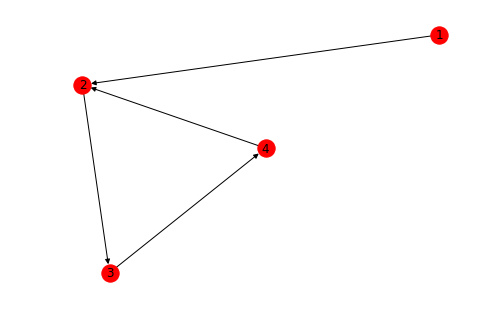

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

plt.clf()

G=nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (3,4), (4,2)])
nx.draw(G, with_labels=True)
plt.show()

Use the function we defined above for the PageRank Algorithm, with $\alpha=0$ to show that the vectors do not converge. (try it for iterations = 500, 501, 502, ... until you see what is going on.

The ranking vectors are periodic as $t$ changes. How long is the period?

What can you say about the eigenvalues of the matrix  $P$  based on this?

In [30]:
for iterations in range(500, 510):
    print(PageRank(G, 0, iterations))

{1: 0.0, 2: 0.25, 3: 0.5, 4: 0.25}
{1: 0.0, 2: 0.25, 3: 0.25, 4: 0.5}
{1: 0.0, 2: 0.5, 3: 0.25, 4: 0.25}
{1: 0.0, 2: 0.25, 3: 0.5, 4: 0.25}
{1: 0.0, 2: 0.25, 3: 0.25, 4: 0.5}
{1: 0.0, 2: 0.5, 3: 0.25, 4: 0.25}
{1: 0.0, 2: 0.25, 3: 0.5, 4: 0.25}
{1: 0.0, 2: 0.25, 3: 0.25, 4: 0.5}
{1: 0.0, 2: 0.5, 3: 0.25, 4: 0.25}
{1: 0.0, 2: 0.25, 3: 0.5, 4: 0.25}


node $1$ has no weight, but other weights cycle through with period 3.

There are 2 complex eigenvalues that are cube roots of unity.  We also have $1$ as an eigenvalue.  [the eigenvectors must be complex, but their imaginary parts cancel at every step]

It is not immediately clear what the other eigenvalue is.

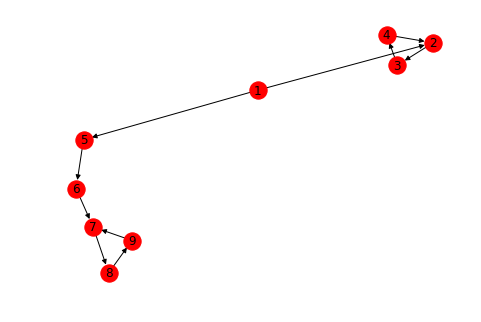

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

plt.clf()

G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (3,4), (4,2), (1,5), (5,6), (6,7), (7,8), (8,9), (9,7)])

nx.draw(G, with_labels=True)
plt.show()

Assume $\alpha = 0$.  Try to work through PageRank by hand.  
- Does it converge, or is there some other behavior (what kind)?
- How would the results change if we didn't assume a uniform $\vec{x}(0)$?
- How would your answers to the 2 questions above change if there were an edge added from $4$ to $7$?


**response**
- It is not converging.  There is cycling for 2, 3, and 4 and cycling for 7, 8, and 9.
- Half of the weight from 1 and all of the weight from 5, 6, 7, 8, and 9 end up in the 7, 8, 9 cycle, while half of the weight from 1 and all of the weight from 2, 3, and 4 end up in the 2,3,4 cycle.  So by shifting the initial condition we could shift these amounts.
- If an edge were added from 4 to 7, eventually all of the weight in the 2,3,4 cycle would leak into the 7, 8, 9 cycle and there would be cycling just in that 1.
**end response**

Modify the PageRank algorithm above to take the initial probabilities $\vec{x}(0)$ as an input.  Returning to the version of the graph before the 4 to 7 edge was added:
- find inputs (summing to 1) that yield weights of 1/3, 1/3, and 1/3 for nodes 2, 3, and 4 and 0 for all other nodes. 
- Find other inputs (summing to 1) that give nodes 7, 8, and 9 weights of 1/3 and 0 for all other nodes.
- try a linear combination of these initial probabilities (ensure that the combination sums to 1).

In [32]:
def PageRankWithInitial(G, alpha, iterations, initial_state):
    r''' initial_state is a dict giving the initial weight of each node in G
    
    For more advanced users, I could make it an optional argument `initial_state = None`,
    and then when I initially assign probabilities, I would have an if statement that if 
    initial_state is None, then give uniform, else use initial_state.
    '''
    
    N = G.order() #count the number of nodes in G which we'll need
    
    probabilities = initial_state  #the initial values
    
    for counter in range(iterations):
        new_probabilities = {node:0 for node in G.nodes()}  #initialize for all nodes.
        for node in G:
            new_probabilities[node] = alpha/N
            for predecessor in G.predecessors(node): #the nodes with edges to `node`.
                new_probabilities[node] += (1-alpha)*probabilities[predecessor]/G.out_degree[predecessor] 
        probabilities = new_probabilities  #can you tell why we need a separate 
                                           #probabilities and new_probabilities dict?
    return probabilities


I'll slightly cheat by noting that I can start out with the input as the final goal and it should work.  But other options definitely work (and if you find them, there are degrees of freedom that is related to other eigenvectors)


In [40]:
initial_state_cycle1 = {}      
for node in G.nodes():
    if node in [2,3,4]:
        initial_state_cycle1[node] = 1./3
    else:
        initial_state_cycle1[node] = 0
        
for iterations in range(3):
    print(iterations, PageRankWithInitial(G, 0, iterations, initial_state_cycle1))
    
print('\n\n\n')

initial_state_cycle2 = {}
for node in G.nodes():
    if node in [7,8,9]:
        initial_state_cycle2[node] = 1./3
    else:
        initial_state_cycle2[node] = 0
        
for iterations in range(3):
    print(iterations, PageRankWithInitial(G, 0, iterations, initial_state_cycle2))


print('\n\n\n')

new_initial_state = {node:0.7*initial_state_cycle1[node] + 0.3*initial_state_cycle2[node] 
                     for node in G.nodes()}

for iterations in range(3):
    print(iterations, PageRankWithInitial(G, 0, iterations, new_initial_state))


0 {1: 0, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
1 {1: 0.0, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
2 {1: 0.0, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}




0 {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
1 {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
2 {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}




0 {1: 0.0, 2: 0.2333333333333333, 3: 0.2333333333333333, 4: 0.2333333333333333, 5: 0.0, 6: 0.0, 7: 0.09999999999999999, 8: 0.09999999999999999, 9: 0.09999999999999999}
1 {1: 0.0, 2: 0.2333333333333333, 3: 0.2333333333333333, 4: 0.2333333333333333, 5: 0.0, 6: 0.0, 7: 0.09999999999999999, 8: 0.099

Add an edge from $4$ to $7$ and from $9$ to $1$ to the network above.

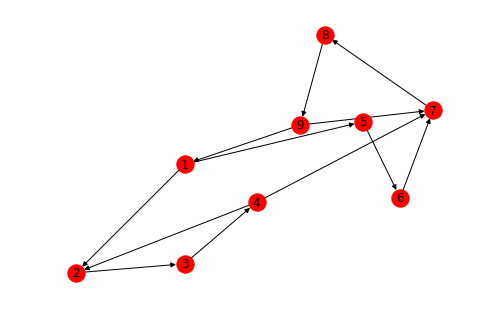

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

plt.clf()

G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (3,4), (4,2), (1,5), (5,6), (6,7), (7,8), (8,9), (9,7)])

G.add_edges_from([(4,7), (9,1)])
nx.draw(G, with_labels=True)
plt.show()

Show that with $\alpha=0$, we are still guaranteed convergence (by Perron-Frobenius).  

Try various initial conditions and see if you can make it converge to different outcomes.  What does your success/failure imply about the eigenvectors of $P$ for $r=1$?

***response***
In this graph, it is possible to get from any node to any node.  Thus it is strongly-connected and we have the version of Perron-Frobenius for irreducible matrices.

This guarantees that there is no other eigenvalue with modulus $1$.

So the system converges.  However we are not guaranteed that $1$ is simple, so it conceivably could converge to different values based on the initial guess.  Let's look at different initial conditions.  We'll use a bunch of random values weights and then normalize them to sum to $1$.

In [44]:
import random

for counter in range(10):
    #try 10 different initial states.
    
    initial_values = {node:random.random() for node in G.nodes()}

    total = 0
    for node in G.nodes():
        total += initial_values[node]

    for node in G.nodes():
        initial_values[node] /= total

    print(PageRankWithInitial(G, 0 , 300, initial_values))


{1: 0.09090908930173958, 2: 0.09090914681534412, 3: 0.09090906309487629, 4: 0.0909090538662708, 5: 0.04545456982336736, 6: 0.045454524955411864, 7: 0.18181820295067241, 8: 0.1818182534915071, 9: 0.1818180957008106}
{1: 0.09090910498632755, 2: 0.0909090851397434, 3: 0.09090907901406421, 4: 0.09090910768769703, 5: 0.045454540509297224, 6: 0.04545454205737992, 7: 0.18181820348766112, 8: 0.18181815977882532, 9: 0.18181817733900418}
{1: 0.09090910170271263, 2: 0.09090911549638026, 3: 0.0909090664700085, 4: 0.09090908532849395, 5: 0.04545455416256639, 6: 0.04545453188185285, 7: 0.1818182108291807, 8: 0.181818201234464, 9: 0.18181813289434054}
{1: 0.09090908899917363, 2: 0.09090912885361307, 3: 0.09090907290036862, 4: 0.09090906500476915, 5: 0.0454545621371628, 6: 0.04545453186597065, 7: 0.18181819475706323, 8: 0.18181823132613023, 9: 0.1818181241557486}
{1: 0.09090912386308699, 2: 0.09090909339739746, 3: 0.09090905461818495, 4: 0.09090912001765045, 5: 0.04545454076925341, 6: 0.04545453145523

They are all giving the same outcome.  This means they have all converged to the same thing.  The probability of this if there were more than one eigenvalue for the eigenvalue $1$ would be incredibly low.  So I believe that there is only one eigenvalue.  